In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
import scipy.io

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# install package 

This is only needed for distances calculations. Since they are calculated once, there is no need to run again the cells in this and next blocks. 

In [ ]:
# to make a directory
%cd 'gdrive/My Drive/traj-dist'

/content/gdrive/My Drive/traj-dist


In [ ]:
# to see in what directory we are in

In [ ]:
pwd

'/content/gdrive/My Drive/traj-dist'

In [ ]:
# to install setup.py from the current directory
!python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'download_urt'
  warnings.warn(msg)
running install
running bdist_egg
running egg_info
writing traj_dist.egg-info/PKG-INFO
writing dependency_links to traj_dist.egg-info/dependency_links.txt
writing requirements to traj_dist.egg-info/requires.txt
writing top-level names to traj_dist.egg-info/top_level.txt
adding license file 'LICENSE.txt'
writing manifest file 'traj_dist.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'traj_dist/cydist/basic_geographical.c' Cython extension (up-to-date)
skipping 'traj_dist/cydist/basic_euclidean.c' Cython extension (up-to-date)
skipping

In [ ]:
!pip install geohash2

# "######################" Now restart runtime "######################"

But don't run above block

In [ ]:
import traj_dist.distance as tdist
import pickle

# Reading data

In [ ]:
mat = scipy.io.loadmat('/content/gdrive/My Drive/Research/Characters/mixoutALL_shifted.mat')

s = set()
for i in range(len(mat['mixout'][0])):
    s.add(mat['mixout'][0][i].shape[1])
print("length of data points belongs to: \n", s)

labels = mat['consts'][0][0][4][0]
print(labels)

Data = [0] * len(mat['mixout'][0])
for j in range(len(Data)):
    Data[j] = [0] * len(mat['mixout'][0][j][0])
    Data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        Data[j][i] = Data[j][i-1] + mat['mixout'][0][j][:2, i]
    Data[j] = np.array(Data[j])
        
Data = np.array(Data, dtype='object')
print(Data.shape)


data = [0] * 20
for i in range(1, 21):
    I = np.where(labels == i)[0]
    data[i-1] = Data[I]
data = np.array(data, dtype='object')

length of data points belongs to: 
 {160, 130, 162, 163, 196, 198, 166, 109, 174, 205, 176, 177, 178, 173, 183, 152}
[ 1  1  1 ... 20 20 20]
(2858,)


In [ ]:
mat = scipy.io.loadmat('/content/gdrive/My Drive/Research/Characters/mixoutALL_shifted.mat')

s = set()
for i in range(len(mat['mixout'][0])):
    s.add(mat['mixout'][0][i].shape[1])
print("length of data points belongs to: \n", s)

length of data points belongs to: 
 {160, 130, 162, 163, 196, 198, 166, 109, 174, 205, 176, 177, 178, 173, 183, 152}


In [ ]:
labels = mat['consts'][0][0][4][0]
labels

array([ 1,  1,  1, ..., 20, 20, 20], dtype=uint8)

In [ ]:
Data = [0] * len(mat['mixout'][0])
for j in range(len(Data)):
    Data[j] = [0] * len(mat['mixout'][0][j][0])
    Data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        Data[j][i] = Data[j][i-1] + mat['mixout'][0][j][:2, i]
    Data[j] = np.array(Data[j])
        
Data = np.array(Data, dtype='object')
Data.shape

(2858,)

In [ ]:
data = [0] * 20
for i in range(1, 21):
    I = np.where(labels == i)[0]
    data[i-1] = Data[I]
data = np.array(data, dtype='object')

## Remove stationary points

In [ ]:
def remove_segments(traj): # removes stationary points
    p2 = traj[:,:2][1:]
    p1 = traj[:,:2][:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>0)[0]
    return traj[I]

### In the following data consists of trajectories with removed stationary points


In [ ]:
for i in range(len(data)):
    data[i] = np.array(list(map(remove_segments, data[i])), dtype='object')
len(data)

20

# Chosen Pairs

In [ ]:
pairs = [[16,18], [10,18], [10,16], [2,8], [3,11]]
pairs = np.array(pairs) - 1
# (u,w), (n,w), (n,u), (b,c), (c,o)

pairs = 15, 17


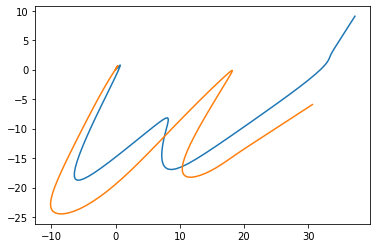

In [ ]:
i = 0 
m, n = pairs[i]
print("pairs =", f"{m},", n)
plt.plot(data[n][0][:,0], data[n][0][:,1])
plt.plot(data[m][0][:,0], data[m][0][:,1])
plt.show()

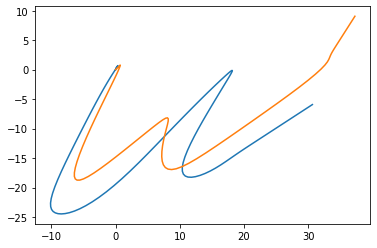

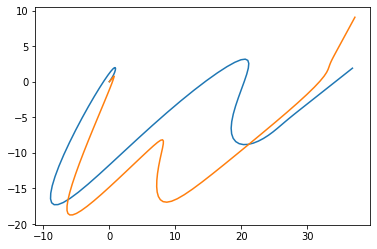

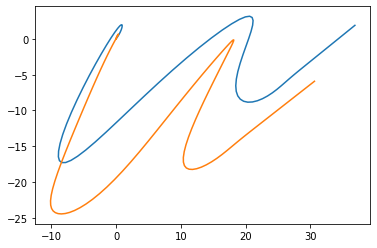

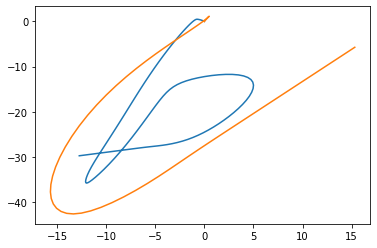

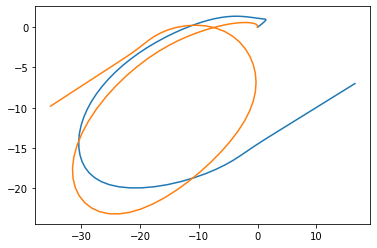

In [ ]:
for n, m in pairs:
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

# KNN with other 7 distances

# From github page: https://github.com/bguillouet/traj-dist

It includes 9 distances for trajectories including: Continuous Frechet, Discrete Frechet, Hausdorff, DTW, SSPD, LCSS, EDR, ERP.

## All but the continuous Frechet distance are really fast.

In [ ]:
# a usage example

traj_list = data[0]
traj_A = traj_list[0]
traj_B = traj_list[1]

# Simple distance
dist = tdist.discret_frechet(traj_A, traj_B)
print(dist)

# Pairwise distance
pdist = tdist.pdist(data[0][:20], metric="hausdorff")
print(pdist)

# Distance between two list of trajectories
cdist = tdist.cdist(data[0][:20], data[1][:20], metric="discret_frechet")
print(cdist)

#### Calculate dustances all together 

'discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp'

In [ ]:
def calculate_dists(data1, data2, pairs_idx, metrics, eps_lcss=1, eps_edr=1): 
    '''pairs_idx: 0 or 1 or 2 or 3 or 4 (it should be aligned with data1 and data2,
                  so that data1 = data[pairs[pair_idx][0]] and data2 = data[pairs[pair_idx][1]])
       eps_lcss: if metric = 'lcss', then eps_lcss is effective.
       eps_edr: if metric = 'edr', then eps_edr is effective.'''
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    for metric in metrics:
        if metric == 'lcss':
            A = tdist.pdist(data, metric, type_d="euclidean", eps=eps_lcss)
        elif metric == 'edr':
            A = tdist.pdist(data, metric, type_d="euclidean", eps=eps_edr)
        else: 
            A = tdist.pdist(data, metric)
        tri = np.zeros((n, n))
        tri[np.triu_indices(n, 1)] = A
        for i in range(1, n):
            for j in range(i):
                tri[i][j] = tri[j][i]
        np.savetxt('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(pairs_idx)+'])/'+metric+'.csv', 
                   tri, delimiter=',')
    total_time = time.time() - start_time
    print(colored(f"total time for pairs[{pairs_idx}]: {total_time}", 'yellow'))
    return total_time

In [ ]:
Metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'lcss', 'edr', 'erp']

# eps_lcss=1, eps_edr=1 are used for pairs[0] and pairs[2]

for i in [0,2]:
    calculate_dists(data[pairs[i][0]], data[pairs[i][1]], pairs_idx=i, 
                    metrics=Metrics, eps_lcss=1, eps_edr=1)

In [ ]:
Metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'lcss', 'edr', 'erp']
#Metrics = ['lcss', 'edr']

# for pairs[1] and pairs[3] and pairs[4] other pairs eps_lcss=2, eps_edr=2 is used. 

for i in [1, 3, 4]:
    calculate_dists(data[pairs[i][0]], data[pairs[i][1]], pairs_idx=i, 
                    metrics=Metrics, eps_lcss=1, eps_edr=2)

#### Calculate distances for continuous Frechet line by line by the following function. Then at the end concatenate them together.

In [ ]:
# Data = np.concatenate((data[pairs[pairs_idx][0]], data[pairs[pairs_idx][1]]), 0)
def calculate_dists_line_by_line_frechet(Data, pairs_idx, start_idx): 
    n = len(Data)
    for i in range(start_idx, n-1):
        start_time = time.time()
        def f(traj):
            return tdist.frechet(Data[i], traj)
        A = list(map(f, Data[i+1:]))
        np.savetxt('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(pairs_idx)+'])/frechet lines/'+str(i)+'.csv', 
                   A, delimiter=',') 
        total_time = time.time() - start_time
        print(f"time for step {i}: {total_time}")
    return total_time

In [ ]:
pairs_idx = 3
start_idx = 0
Data = np.concatenate((data[pairs[pairs_idx][0]], data[pairs[pairs_idx][1]]), 0)
calculate_dists_line_by_line_frechet(Data, pairs_idx=pairs_idx, start_idx=start_idx)

### To stack the 1d generated vectors together to get the distance matrix of continuous Frechet distance we will use the following get_matrix function.

In [ ]:
def get_matrix(pairs_idx, path):
    '''
    path example: 
    /content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(pairs_idx)+'])/frechet lines/
    '''
    n = len(data[pairs[pairs_idx][0]]) + len(data[pairs[pairs_idx][1]])
    matrix = np.zeros((n,n))
    for i in range(n-1):
        #matrix[i][i+1:] = np.array(pd.read_csv(path+str(i)+'.csv', header=None)).reshape(n-i-1,)
        matrix[i][i+1:] = np.loadtxt(path+str(i)+'.csv')
    for i in range(1, n):
        for j in range(i):
            matrix[i][j] = matrix[j][i]
    np.savetxt(path[:-14]+'frechet.csv', matrix, delimiter=',')
    return matrix

In [ ]:
for pairs_idx in [0, 1, 2, 3, 4]:
    path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(pairs_idx)+'])/frechet lines/'
    A = get_matrix(pairs_idx, path)

# KNN with 8 distances: 

### Continuous Frechet, Discrete Frechet, Hausdorff, DTW, SSPD, LCSS, EDR, ERP

In [ ]:
def KNN_with_dists(n_1, n_2, dists_names, paths_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/sspd.csv'
       dists_names: a list of distance names
       paths_to_dists: the paths list to the corresponding distancas (each path 
                       points out to the corresponding distance matrix)
       n_1: len(data_1)
       n_2: len(data_2)
       dist_name: the name of distance used to calculate sitance matrix 
       (the name is taken from a list above called metrics)'''

    train_errors = np.zeros(len(dists_names))
    test_errors = np.zeros(len(dists_names))

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1]*n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    for i in range(len(dists_names)):

        dist_matrix = np.array(pd.read_csv(paths_to_dists[i],  header=None))

        D_train = dist_matrix[I][:, I]
        D_test = dist_matrix[J][:,I]
        train_labels = labels[I]
        test_labels = labels[J]

        clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
        
        #Train the model using the training sets
        clf.fit(D_train, list(train_labels))

        #Predict labels for train dataset
        train_pred = clf.predict(D_train)
        train_errors[i] = sum(train_labels != train_pred)/len(I)
        
        #Predict labels for test dataset
        test_pred = clf.predict(D_test)
        test_errors[i] = sum((test_labels != test_pred))/len(J)
        
    return train_errors, test_errors

In [ ]:
def KNN_average_error(data1, data2, num_trials, dists_names, paths_to_dists):

    '''dists_names: a list of distance names
       paths_to_dists: the paths list to the corresponding distancas (each path 
                       points out to the corresponding distance matrix)'''

    Start_time = time.time()

    train_errors = np.zeros((num_trials, len(dists_names)))
    test_errors = np.zeros((num_trials, len(dists_names)))

    for i in range(num_trials):
        tr_errors, ts_errors = KNN_with_dists(len(data1), len(data2), dists_names, paths_to_dists)
        train_errors[i] = tr_errors
        test_errors[i] = ts_errors

    train_error = np.mean(train_errors, axis=0)
    test_error = np.mean(test_errors, axis=0)
    std_test_error = np.std(test_errors, axis=0)

    Dict = {}
    for i in range(len(dists_names)):
        Dict[i+1] = [f"KNN with {dists_names[i]}", 
                     np.round(train_error[i], decimals = 4), 
                     np.round(test_error[i], decimals = 4), 
                     np.round(std_test_error[i], decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, train_errors, test_errors, train_error, test_error)

In [ ]:
Metrics = ['frechet', 'discret_frechet', 'hausdorff', 'dtw', 'lcss', 'sspd',
           'edr', 'erp']
test_errors = []
test_stds = []

for j in range(len(pairs)):
    paths = []
    print(colored(f"pairs: {pairs[j]}", 'yellow'))
    for i in range(len(Metrics)):
        paths.append('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(j)+'])/'+Metrics[i]+'.csv')

    F = KNN_average_error(data[pairs[j][0]], data[pairs[j][1]], num_trials=50, 
                          dists_names=Metrics, paths_to_dists=paths)
    test_errors.append(np.array(F[0])[:, 2])
    test_stds.append(np.array(F[0])[:, 3])
    print(F[0])
    print(colored("============================================================", 'red'))

test_errors = np.array(test_errors)
test_stds = np.array(test_stds)

print(colored(f'mean test errors: {list(np.round(list(np.mean(test_errors, 0)), decimals=4))}', 'yellow'))
print(colored(f'mean of stds:     {list(np.round(list(np.mean(test_stds, 0)), decimals=4))}', 'blue'))

pairs: [15 17]
num_trials = 50
total time = 19.0954270362854
                 Classifier  Train Error  Test Error     std
1          KNN with frechet       0.0460      0.0682  0.0307
2  KNN with discret_frechet       0.0482      0.0728  0.0289
3        KNN with hausdorff       0.0455      0.0703  0.0298
4              KNN with dtw       0.0635      0.1100  0.0334
5             KNN with lcss       0.0906      0.1503  0.0386
6             KNN with sspd       0.0785      0.1241  0.0349
7              KNN with edr       0.1184      0.1731  0.0395
8              KNN with erp       0.0184      0.0282  0.0181
pairs: [ 9 17]
num_trials = 50
total time = 18.696921586990356
                 Classifier  Train Error  Test Error     std
1          KNN with frechet       0.1137      0.1813  0.0410
2  KNN with discret_frechet       0.1065      0.1691  0.0404
3        KNN with hausdorff       0.1146      0.1870  0.0408
4              KNN with dtw       0.1378      0.2117  0.0420
5             KNN with

# KNN with fastdtw which is an approximate dtw

In [ ]:
pip install fastdtw

In [ ]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [ ]:
def calculate_fastdtw_dists(data1, data2): 
    X = np.concatenate((data1, data2), 0)
    n = len(X)
    matrix = np.zeros((n, n))

    for i in range(n):
        matrix[i][i:] = [fastdtw(X[i], X[j])[0] for j in range(i, n)]

    for i in range(1, n):
        for j in range(i):
            matrix[i][j] = matrix[j][i]
    return matrix

In [ ]:
def KNN_with_fastdtw(n_1, n_2, dist_matrix):
    '''n_1: len(data_1)
       n_2: len(data_2)
       dist_name: the name of distance used to calculate sitance matrix 
       (the name is taken from a list above called metrics)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1]*n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_errors = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_errors = sum((test_labels != test_pred))/len(J)
        
    return train_errors, test_errors

In [ ]:
def KNN_fastdtw_average_error(data1, data2, dist_matrix, num_trials):

    '''dists_names: a list of distance names
       paths_to_dists: the paths list to the corresponding distancas (each path 
                       points out to the corresponding distance matrix)'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        tr_errors, ts_errors = KNN_with_fastdtw(len(data1), len(data2), dist_matrix)
        train_errors[i] = tr_errors
        test_errors[i] = ts_errors

    train_error = np.mean(train_errors)
    test_error = np.mean(test_errors)
    std_test_error = np.std(test_errors)

    Dict = {}
    Dict[1] = [f"KNN with fastdtw", np.round(train_error, decimals = 4), 
               np.round(test_error, decimals = 4), 
               np.round(std_test_error, decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time for averaging = {time.time() - Start_time}', 'green'))

    return (df, train_errors, test_errors, train_error, test_error)

In [ ]:
test_errors_fastdtw = []
test_stds_fastdtw = []
for j in range(len(pairs)):
    m, n = pairs[j]
    fastdtw_matrix = calculate_fastdtw_dists(data[m], data[n])

    E = KNN_fastdtw_average_error(data[m], data[n], dist_matrix=fastdtw_matrix, num_trials=50)
    print(E[0])
    test_errors_fastdtw.append(np.array(E[0])[0][2])
    test_stds_fastdtw.append(np.array(E[0])[0][3])
    print(colored("====================================================", 'red'))

test_errors_fastdtw = np.array(test_errors_fastdtw)
test_stds_fastdtw = np.array(test_stds_fastdtw)

print(colored(f'mean test errors: {np.round(np.mean(test_errors_fastdtw), decimals=4)}', 'magenta'))
print(colored(f'mean of stds:     {np.round(np.mean(test_stds_fastdtw), decimals=4)}', 'blue'))

num_trials = 50
total time for averaging = 0.5238537788391113
         Classifier  Train Error  Test Error     std
1  KNN with fastdtw       0.0421      0.0751  0.0232
num_trials = 50
total time for averaging = 0.5313422679901123
         Classifier  Train Error  Test Error    std
1  KNN with fastdtw       0.0626      0.1239  0.036
num_trials = 50
total time for averaging = 0.5465335845947266
         Classifier  Train Error  Test Error     std
1  KNN with fastdtw       0.0237      0.0377  0.0178
num_trials = 50
total time for averaging = 0.6626520156860352
         Classifier  Train Error  Test Error  std
1  KNN with fastdtw          0.0         0.0  0.0
num_trials = 50
total time for averaging = 0.5788302421569824
         Classifier  Train Error  Test Error  std
1  KNN with fastdtw          0.0         0.0  0.0
mean test errors: 0.0473
mean of stds:     0.0154


# KNN with LSH

In [ ]:
pip install trjtrypy

In [ ]:
from google.colab import files
files.upload()

#import KNN_with_LSH_class
from KNN_with_LSH_class import KNN_with_LSH

Saving KNN_with_LSH_class.py to KNN_with_LSH_class.py


In [ ]:
test_errors_LSH = []
test_stds_LSH = []
for j in range(len(pairs)):
    m, n = pairs[j]
    KNN_with_LSH_class = KNN_with_LSH(data[m], data[n], number_circles=20, num_trials=50)
    E = KNN_with_LSH_class.KNN_LSH_average_error()
    print(E[0])
    test_errors_LSH.append(np.array(E[0])[0][2])
    test_stds_LSH.append(np.array(E[0])[0][3])
    print(colored("================================================", 'red'))

test_errors_LSH = np.array(test_errors_LSH)
test_stds_LSH = np.array(test_stds_LSH)

print(colored(f'mean test errors: {np.round(np.mean(test_errors_LSH), decimals=4)}', 'magenta'))
print(colored(f'mean of stds:     {np.round(np.mean(test_stds_LSH), decimals=4)}', 'blue'))

num_trials = 50
total time = 8.590339183807373
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.1243      0.1841  0.0427
num_trials = 50
total time = 8.378520250320435
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.1871       0.294  0.0559
num_trials = 50
total time = 8.615057229995728
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.1374      0.1719  0.0536
num_trials = 50
total time = 9.734510898590088
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.1323      0.1844  0.0631
num_trials = 50
total time = 8.654668807983398
     Classifier  Train Error  Test Error     std
1  KNN with LSH       0.1035      0.1393  0.0476
mean test errors: 0.1947
mean of stds:     0.0526
